In [1]:
import constants
import pandas as pd
import numpy as np
from sklearn import impute as skImpute
from sklearn import preprocessing
from sklearn import metrics
from sklearn import neighbors
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
from scipy import stats
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [2]:
# Define training, testing, and all datasets
training = ['ins2', 'ins6', 'n11', 'n2', 'nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15', 'plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6', 'rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']
testing = ['ins8', 'ins9', 'n5', 'nfle16', 'nfle17', 'nfle18', 'nfle19', 'plm7', 'plm8', 'plm9', 'rbd18', 'rbd19', 'rbd20']

allData = training + testing

In [3]:
# Define Top 5 & Top 10 columns
safe_cols = ['Patient', 'epoch', 'sleep_stage', 'gender', 'rbd', 'ins', 'nfle', 'plm', 'age']
top_5_cols = safe_cols + ['perm_entropy', 'beta_relative_power', 'alpha_relative_power', 'EOG_ECB', 'EMG_epochEnergy']
top_10_cols = safe_cols + ['perm_entropy', 'beta_relative_power', 'alpha_relative_power', 'EOG_ECB', 'EMG_epochEnergy', 'delta_relative_power', 'theta_relative_power', 'katz', 'EMG_epochEnergy_x', 'lof'] 

In [4]:
# Combine all data
firstNumericCol = 6 # Includes age
filepath = r"C:\Users\bryce\Documents\projects\psg_project\data\\"
final = pd.DataFrame()

for dataset in allData: # Stuff in the loop is done on each dataset individually before combining
    thisData = pd.read_csv(filepath + dataset + '.csv') # Create an untracked local data folder
    column_names = thisData.columns[firstNumericCol - 1:]

    # Add a patient column based on the file name so can be used to do groupby operations
    thisData.insert(1, "Patient", dataset)

    # Truncate based on shortest column before NaN's:
    lastNonNaNEachCol = thisData.notna()[::-1].idxmax()
    thisData = thisData.truncate(after = min(lastNonNaNEachCol))
    
    # Fill in missing data using KNN
    impute_KNN = thisData.iloc[:, firstNumericCol:]
    imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
    thisData.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)

    # Combine with full dataset
    if final.empty:
        final = thisData
    else:
        final = pd.concat([final, thisData])
    
# Drop current "_norm" cols:
for col in final.columns:
    if "_norm" in col:
        final.drop(col, axis=1, inplace=True)

# Normalize (Divide by average within same patient):
for patient in final["Patient"].unique():
    thisPatientMeans = final[final["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    final[final["Patient"] == patient].iloc[:, firstNumericCol:] -= thisPatientMeans
    
#Box-Cox
for column in final.columns[firstNumericCol:]:
    try:
        final[column] = final[column].abs()
        box_cox_trans = stats.boxcox(final[column])[0]
        final[column] = box_cox_trans
    except:
        continue
    
print("Box-Cox completed.")  

#Robust Scaling
subset1 = final.iloc[:,:firstNumericCol]
subset2 = final.iloc[:,firstNumericCol:]

scaler = preprocessing.RobustScaler() # By default, centers and scales
robust_df = scaler.fit_transform(subset2)
final.iloc[:, firstNumericCol:] = robust_df
print("Robust Scaling completed.")

# Outlier Removal (Local Outlier Factor)
n_neighbors = 20
LOF = neighbors.LocalOutlierFactor(n_neighbors = 20)
LOF.fit_predict(final.iloc[:, firstNumericCol:])
lof_factors = LOF.negative_outlier_factor_
final['lof'] = lof_factors
quartiles = final['lof'].abs().quantile([0.25, 0.75])
interQuartileRange = quartiles[0.75] - quartiles[0.25]
outlierCutoff = -1000
outliers = final[final['lof'] <= outlierCutoff]
final = final[final['lof'] > outlierCutoff]
display(outliers)


#Encoding (Sleep Stage)
final.drop("Unnamed: 0", axis=1, inplace=True)

final.insert(2, "sleep_stage", np.zeros(len(final)))

for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

final.drop("Sleep Stage", axis=1, inplace=True)

# Encoding (Condition)
conditionColumns = pd.DataFrame()
for patient in pd.unique(final['Patient']):
    thisPatientSeries = (final[final['Patient'] == patient])["condition"]
    thisPatientDf = thisPatientSeries.to_frame("condition")
    for condition in constants.CONDITION_TO_BINARY:
        if condition == thisPatientDf.at[0, 'condition']:
            binary = constants.CONDITION_TO_BINARY.get(condition)

            if binary[0] == 0:
                thisPatientDf.insert(1, "condition_0", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(1, "condition_0", np.ones(len(thisPatientDf)))

            if binary[1] == 0:
                thisPatientDf.insert(2, "condition_1", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(2, "condition_1", np.ones(len(thisPatientDf)))

            if binary[2] == 0:
                thisPatientDf.insert(3, "condition_2", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(3, "condition_2", np.ones(len(thisPatientDf)))

            if binary[3] == 0:
                thisPatientDf.insert(4, "condition_3", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(4, "condition_3", np.ones(len(thisPatientDf)))
    
    if conditionColumns.empty:
        conditionColumns = thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]
    else: # ConditionColumns already initialized
        conditionColumns = pd.concat([conditionColumns, thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]])
final.insert(5, "rbd", conditionColumns["condition_0"])
final.insert(6, "ins", conditionColumns["condition_1"])
final.insert(7, "nfle", conditionColumns["condition_2"])
final.insert(8, "plm", conditionColumns["condition_3"])

final.drop("condition", axis=1, inplace=True)

print('Encoding completed.')

final.reset_index(inplace=True)
final = final.iloc[:,1:]
final.to_csv('final.csv')
print('Dataset successfully exported!')

C:\Users\bryce\AppData\Local\Temp\ipykernel_12648\3340074370.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[final["Patient"] == patient].iloc[:, firstNumericCol:] -= thisPatientMeans
c:\Users\bryce\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Box-Cox completed.
Robust Scaling completed.


,Unnamed: 0,Patient,epoch,Sleep Stage,condition,gender,age,beta_relative_power,alpha_relative_power,theta_relative_power,...,hf_ECG1-ECG2,lf/hf_ECG1-ECG2,breathingrate_ECG1-ECG2,bpm_PLETH,rmssd_PLETH,lf_PLETH,hf_PLETH,lf/hf_PLETH,breathingrate_PLETH,lof
190,190,ins2,190,W,Insomnia,F,0.000000,0.454037,-1.176151,-0.552765,...,6.887805e-02,0.689694,0.333333,-0.124347,-0.013450,5.534437e+27,4.736679e+28,-0.898357,-0.666667,-1.859611e+03
1185,1185,ins2,1185,R,Insomnia,F,0.000000,1.036815,-0.430046,0.876152,...,4.699248e+44,-0.205184,-0.666667,-0.690101,-0.290553,2.225948e-01,2.045675e+00,-0.617405,0.000000,-1.226182e+12
1303,1303,ins2,1303,S2,Insomnia,F,0.000000,0.233150,0.169111,-0.526742,...,3.436738e+41,-0.368229,0.000000,-0.995133,-0.791854,-4.235815e-01,1.516087e-01,-0.558591,-0.333333,-7.121409e+39
1023,1023,ins6,1023,W,Insomnia,F,-0.140305,-0.170820,-1.193123,-0.662161,...,4.306913e+33,-0.356521,0.695364,-0.040031,-0.064104,-6.710101e-01,1.492888e-01,-0.793319,0.677355,-1.859290e+09
451,451,n11,451,S2,Normal,F,-0.937731,-0.577583,-0.277245,0.073873,...,6.815032e+23,-0.289906,-0.333333,0.186081,0.449146,-6.753968e-01,-5.431313e-01,-0.449911,0.333333,-2.340285e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,442,plm8,442,S4,Periodic Leg Movement,M,0.071700,-0.404422,0.185165,0.520811,...,-2.153035e-01,2.430937,-1.000000,-1.029277,-1.035718,5.035365e+40,7.066954e+41,-0.948199,0.333333,-3.634046e+10
75,75,plm9,75,S4,Periodic Leg Movement,M,0.000000,-1.721473,-1.412406,-1.113724,...,-2.111492e-01,1.048603,0.000000,0.854975,-0.029197,1.454979e+40,8.520554e+39,0.840788,-0.666667,-3.278326e+09
169,169,plm9,169,R,Periodic Leg Movement,M,0.000000,0.220507,0.426691,0.654795,...,-1.929599e-01,0.972353,0.000000,0.328901,0.717486,1.109215e+49,9.275053e+49,-0.895351,1.000000,-3.396175e+48
515,515,plm9,515,W,Periodic Leg Movement,M,0.000000,-0.304035,0.574529,-1.122929,...,1.954071e+31,-0.191500,-0.333333,-0.233045,0.369178,2.171260e+00,7.134066e-01,0.945109,-0.666667,-7.845860e+07


C:\Users\bryce\AppData\Local\Temp\ipykernel_12648\3340074370.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.drop("Unnamed: 0", axis=1, inplace=True)
C:\Users\bryce\AppData\Local\Temp\ipykernel_12648\3340074370.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.drop("Sleep Stage", axis=1, inplace=True)
C:\Users\bryce\AppData\Local\Temp\ipykernel_12648\3340074370.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f

Encoding completed.
Dataset successfully exported!


In [5]:
# Function for Plotting PSA, TSNE, or Clusters:
def plot_dimReduction(dataToPlot, label, label_meaning = "target", scaleFactors = [1, 1, 1], eliv = None, azim = None):
    cols = np.shape(dataToPlot)[1]
    if cols == 1:
        # 1D Plot
        #sf = 10**49
        sf = scaleFactors[0]
        df_reduced = pd.DataFrame(dataToPlot / sf, columns=["pca_feature_1"])
        df_reduced[label_meaning] = label

        # Creating dataset
        np.random.seed(10)
        
        data_0 = df_reduced.loc[df_reduced[label_meaning] == 0, "pca_feature_1"]
        data_1 = df_reduced.loc[df_reduced[label_meaning] == 1, "pca_feature_1"]
        data_2 = df_reduced.loc[df_reduced[label_meaning] == 2, "pca_feature_1"]
        data_3 = df_reduced.loc[df_reduced[label_meaning] == 3, "pca_feature_1"]
        data_4 = df_reduced.loc[df_reduced[label_meaning] == 4, "pca_feature_1"]
        data_5 = df_reduced.loc[df_reduced[label_meaning] == 5, "pca_feature_1"]
        data = [data_0, data_1, data_2, data_3, data_4, data_5]
        
        fig = plt.figure(figsize=(10,5))
        
        # Configure axes
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
        plt.xlabel("sleep_stage")
        plt.ylabel("feature_1")
        
        # Creating plot (handles outliers)
        bp = ax.boxplot(data, showfliers=False)  

        # show plot
        plt.show()

    elif cols == 2:
        # Dataframe
        df_reduced = pd.DataFrame(dataToPlot, columns=["feature_1", "feature_2"])
        df_reduced[label_meaning] = label

        # Outlier Removal
        original_rows = len(df_reduced)
        df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
        print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

        # Optional Code to Correctly Scale/Reduce
        #df_reduced = df_reduced[df_reduced["feature_1"] < 0]

        # 2D Plot
        fig = plt.figure(figsize=(10,10))
        sns.scatterplot(data=df_reduced, x="feature_1", y="feature_2", hue=label_meaning, palette="deep")

        fig.show()

    elif cols == 3:
        # Dataframe
        df_reduced = pd.DataFrame(dataToPlot, columns=["feature_1", "feature_2", "feature_3"])
        df_reduced[label_meaning] = label
        # Outlier Removal
        original_rows = len(df_reduced)
        df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
        print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

        # Optional Scaling Factor
        #sf_x = 10**45
        sf_x = scaleFactors[0]
        sf_y = scaleFactors[1]
        sf_z = scaleFactors[2]

        # 3D Plot
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection = '3d')
        cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
        sc = ax.scatter(xs=df_reduced["feature_1"] / sf_x, ys=df_reduced["feature_2"] / sf_y, zs=df_reduced["feature_3"] / sf_z, c=df_reduced[label_meaning], cmap=cmap)
        if eliv and azim:
            ax.view_init(eliv, azim)

        # Axes
        ax.set_xlabel('feature_1')
        ax.set_ylabel('feature_2')
        ax.set_zlabel('feature_3')

        # Legend
        plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

        # Optional Scaling
        # plt.xlim([-1.2554, -1.2548])

        plt.show()

In [6]:
# Function for running PCA or TSNE or Isomap
def dimReduction(dataToReduce, type = "PCA", n_components = 2, perplexity = 30, n_iters = 1000, simplifiedTarget = False):
    data = dataToReduce.iloc[:,8:].to_numpy()
    target = dataToReduce.loc[:, "sleep_stage"].to_numpy()
    if type == "PCA":
        model = PCA(n_components = n_components)
        data_reduced = model.fit_transform(data)
    elif type == "TSNE":
        model = TSNE(n_components = n_components, perplexity = perplexity, n_iter = n_iters)
        data_reduced = model.fit_transform(data)
    elif type == "Isomap":
        # Isomap:
        model = manifold.Isomap(n_neighbors = 12, n_components = n_components)
        model.fit(data)
        data_reduced = model.transform(data)

    if simplifiedTarget:
        simplifiedTarget = []
        for i in target:
            if i >= 1.0 and i <= 4.0:
                simplifiedTarget.append(1.0)
            elif i == 5.0:
                simplifiedTarget.append(2.0)
            else:
                simplifiedTarget.append(0.0)
        target = np.array(simplifiedTarget)

    return data_reduced, target

In [7]:
# Define Top 5 & Top 10 datasets
training_top_5 = final.loc[final["Patient"].isin(training), top_5_cols]
testing_top_5 = final.loc[final["Patient"].isin(testing), top_5_cols]

training_top_10 = final.loc[final["Patient"].isin(training), top_10_cols]
testing_top_10 = final.loc[final["Patient"].isin(testing), top_10_cols]

0.725209933893157
0.6672443653865591


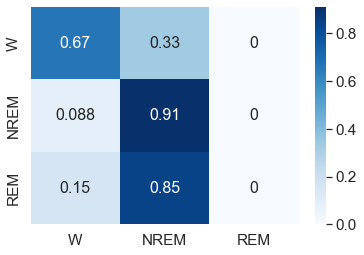

In [16]:
n_components = 1

# Perform PCA/TSNE on training data and plot results
dataset = training_top_5
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_5
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.7377166339110237
0.6785110079133576


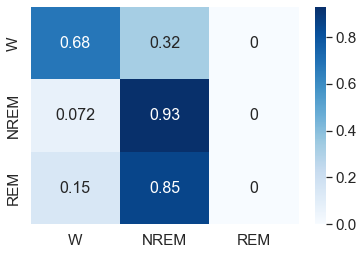

In [17]:
n_components = 2

# Perform PCA/TSNE on training data and plot results
dataset = training_top_5
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_5
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.7424513132035019
0.6830946522870506


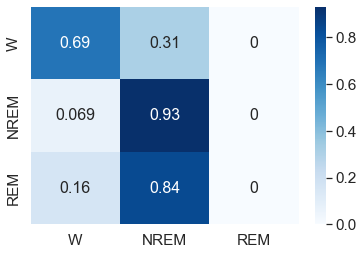

In [18]:
n_components = 3

# Perform PCA/TSNE on training data and plot results
dataset = training_top_5
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_5
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.735483294622119
0.6764366088434547


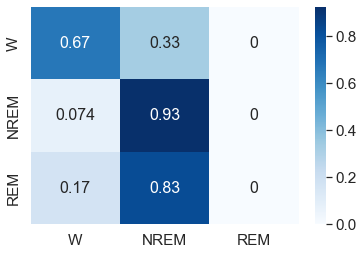

In [19]:
n_components = 4

# Perform PCA/TSNE on training data and plot results
dataset = training_top_5
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_5
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.7401286403430409
0.6809144878289535


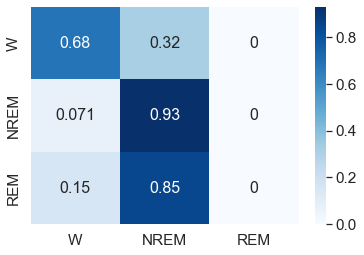

In [20]:
n_components = 5

# Perform PCA/TSNE on training data and plot results
dataset = training_top_5
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_5
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.6246203323208862
0.4809653180836052


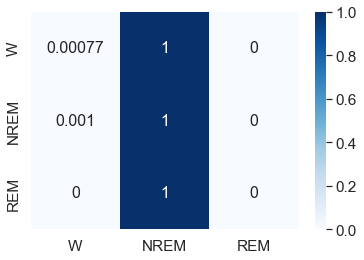

In [12]:
n_components = 1

# Perform PCA/TSNE on training data and plot results
dataset = training_top_10
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_10
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.6247989994639985
0.4810502274919663


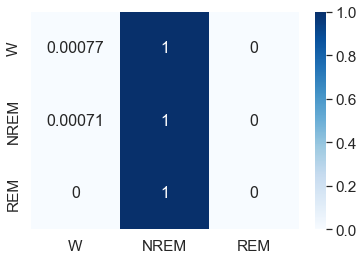

In [13]:
n_components = 2

# Perform PCA/TSNE on training data and plot results
dataset = training_top_10
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_10
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.6827764874039665
0.6045157566442214


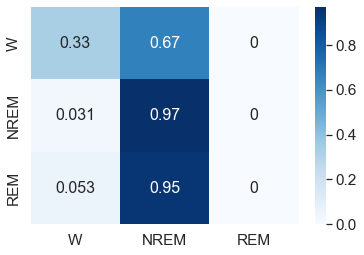

In [9]:
n_components = 3

# Perform PCA/TSNE on training data and plot results
dataset = training_top_10
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_10
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.718152581740218
0.6580151179838558


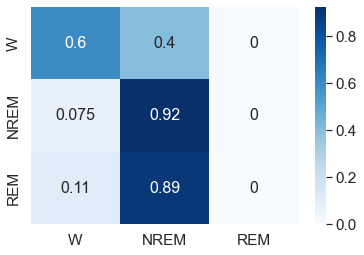

In [10]:
n_components = 4

# Perform PCA/TSNE on training data and plot results
dataset = training_top_10
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_10
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

0.7205645881722351
0.660257225824195


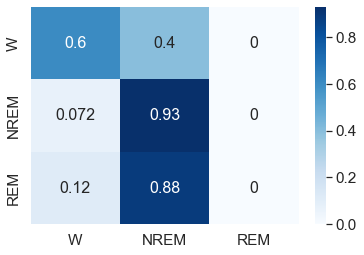

In [11]:
n_components = 5

# Perform PCA/TSNE on training data and plot results
dataset = training_top_10
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_10
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
model.fit(reduced_training, target_training)

# Test accuracy
predictions = model.predict(reduced_testing)
accuracy = accuracy_score(target_testing, predictions)
f1 = f1_score(target_testing, predictions, average = 'weighted')
print(accuracy)
print(f1)

# Confusion Matrix
conf = metrics.confusion_matrix(target_testing, predictions)
ind_accs = conf/(conf.sum(axis=1, keepdims=True))
df_cm = pd.DataFrame(ind_accs, index = ['W', 'NREM', 'REM'], columns = ['W', 'NREM', 'REM'])
sns.set(font_scale=1.4) # Label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Font size
plt.show()

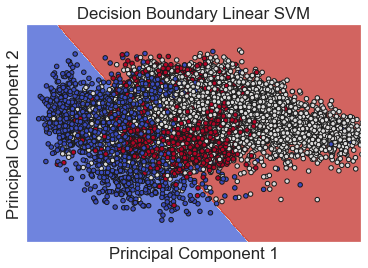

In [18]:
n_components = 2

# Perform PCA/TSNE on training data and plot results
dataset = training_top_5
reduced_training, target_training = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Perform PCA/TSNE on testing data and plot results
dataset = testing_top_5
reduced_testing, target_testing = dimReduction(dataset, type = "PCA", n_components = n_components, simplifiedTarget = True)

# Create model
model = svm.SVC(kernel='linear')
clf = model.fit(reduced_training, target_training)

X = reduced_testing
y = target_testing

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()

# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_title('Decision Boundary Linear SVM')
ax.set_ylabel('Principal Component 2')
ax.set_xlabel('Principal Component 1')
ax.set_xticks(())
ax.set_yticks(())
plt.xlim([-3, 3]) # HARDCODED BC OUTLIERS
plt.ylim([-4, 3]) # HARDCODED BC OUTLIERS
plt.show()